In [1]:
import kagglehub
path = kagglehub.dataset_download("marklvl/sentiment-labelled-sentences-data-set")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Easha\.cache\kagglehub\datasets\marklvl\sentiment-labelled-sentences-data-set\versions\2


In [2]:
import pandas as pd
file_path = path + "/amazon_cells_labelled.txt"
df = pd.read_csv(file_path, sep='\t', names=['review', 'sentiment'])
#0=negative, 1=positive
df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
df= df.dropna()

In [7]:
#understanding data
print(df.columns)
print(df.shape)
print(df.dtypes)
df['sentiment'].value_counts()

Index(['review', 'sentiment'], dtype='object')
(1000, 2)
review       object
sentiment     int64
dtype: object


sentiment
0    500
1    500
Name: count, dtype: int64

In [16]:
#data cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['cleaned_review']= df['review'].apply(lambda x: x.lower())                                     #lowercase

df['cleaned_review']= df['cleaned_review'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))               #remove punctuation

df['cleaned_review']= df['cleaned_review'].apply(lambda x: x.split())                                #tokenize

df['cleaned_review']= df['cleaned_review'].apply(lambda x: [w for w in x if w not in stop_words])    #remove stopwords

stemmer = PorterStemmer()
df['cleaned_review']= df['cleaned_review'].apply(lambda x: [stemmer.stem(w) for w in x])             #stemming

df['cleaned_review']= df['cleaned_review'].apply(lambda x: ' '.join(x))                              #join words back


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Easha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.head()

,review,sentiment,cleaned_review
0,So there is no way for me to plug it in here i...,0,way plug us unless go convert
1,"Good case, Excellent value.",1,good case excel valu
2,Great for the jawbone.,1,great jawbon
3,Tied to charger for conversations lasting more...,0,tie charger convers last minutesmajor problem
4,The mic is great.,1,mic great


In [20]:
#vectorization by tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(max_features=5000)
X= vectorizer.fit_transform(df['cleaned_review'])
print(vectorizer.get_feature_names_out())

['abhor' 'abil' 'abl' ... 'youll' 'za' 'zero']


In [22]:
#test train sets
from sklearn.model_selection import train_test_split
#review=x axis, sentiment=y axis
y= df['sentiment']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)


In [172]:
#1. naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nbModel= MultinomialNB()
nbModel.fit(X_train, y_train)
y_pred_nb= nbModel.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Accuracy: 0.82
Confusion Matrix:
 [[75 18]
 [18 89]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        93
           1       0.83      0.83      0.83       107

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



In [174]:
#2. logistic regression
from sklearn.linear_model import LogisticRegression

lrModel= LogisticRegression(max_iter=1000)
lrModel.fit(X_train, y_train)
y_pred_lr= lrModel.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.795
Confusion Matrix:
 [[80 13]
 [28 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.80        93
           1       0.86      0.74      0.79       107

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



In [180]:
#comparing with pretrained models
!pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ------------------------------- ------ 524.3/624.3 kB 621.2 kB/s eta 0:00:01
   -------------------------------------- 624.3/624.3 kB 565.0 kB/s eta 0:00:00


In [182]:
#1. textblob
from textblob import TextBlob

test_data= df.iloc[y_test.index]['review']
tb_pred= test_data.apply(lambda x:TextBlob(x).sentiment.polarity)
tb_pred= tb_pred.apply(lambda p:1 if p>0 else 0)        #positve>0 negative<0

print("Accuracy:", accuracy_score(y_test, tb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, tb_pred))
print("Classification Report:\n", classification_report(y_test, tb_pred))

Accuracy: 0.795
Confusion Matrix:
 [[68 25]
 [16 91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77        93
           1       0.78      0.85      0.82       107

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



In [34]:
#insights
from collections import Counter
pos= ' '.join(df[df['sentiment'] == 1]['cleaned_review']).split()
neg= ' '.join(df[df['sentiment'] == 0]['cleaned_review']).split()

In [32]:
Counter(pos).most_common(10)

[('great', 92),
 ('phone', 91),
 ('work', 74),
 ('good', 64),
 ('use', 38),
 ('headset', 35),
 ('product', 33),
 ('qualiti', 31),
 ('well', 31),
 ('sound', 30)]

In [30]:
Counter(neg).most_common(10)

[('phone', 83),
 ('work', 38),
 ('use', 33),
 ('dont', 26),
 ('batteri', 23),
 ('product', 23),
 ('ear', 21),
 ('disappoint', 21),
 ('headset', 20),
 ('time', 19)]

In [38]:
!pip install wordcloud

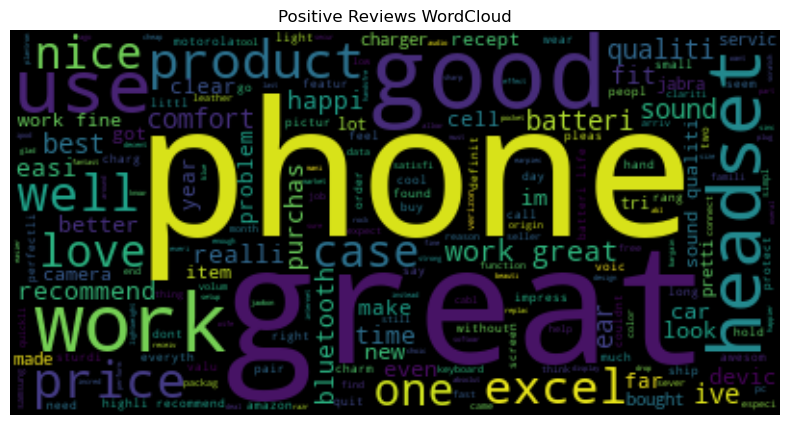

In [46]:
#plot positive words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos= ' '.join(df[df['sentiment'] == 1]['cleaned_review'])
wordcloud = WordCloud().generate(pos_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")
plt.show()
